In [16]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df_credit = pd.read_csv('D:/Submission/data/credit_scoring.csv')
df_credit.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


# EDA

In [9]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   application_id     6000 non-null   int64  
 1   age                6000 non-null   int64  
 2   monthly_income     6000 non-null   int64  
 3   loan_amount        6000 non-null   int64  
 4   previous_defaults  6000 non-null   int64  
 5   credit_score       6000 non-null   int64  
 6   default            6000 non-null   int64  
 7   leak_col_good      6000 non-null   int64  
 8   leak_col_subtle    6000 non-null   float64
dtypes: float64(1), int64(8)
memory usage: 422.0 KB


In [10]:
df_credit.describe()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
count,6000.000000,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,503999.500000,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167,0.012167,0.011945
std,1732.195139,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639,0.109639,0.113947
min,501000.000000,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000,0.000000,-0.119000
25%,502499.750000,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000,0.000000,-0.020000
50%,503999.500000,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000,0.000000,0.000000
75%,505499.250000,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000,0.000000,0.021000
max,506999.000000,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000,1.000000,1.092000


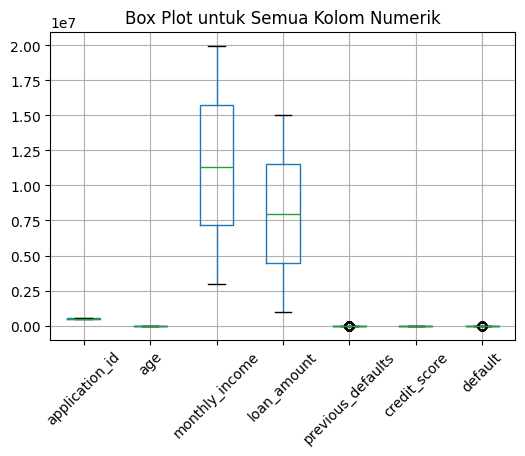

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

kolom_numerik = df_credit.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(6, 4))
df_credit[kolom_numerik].boxplot(rot=45)
plt.title('Box Plot untuk Semua Kolom Numerik')
plt.grid(True)
plt.show()

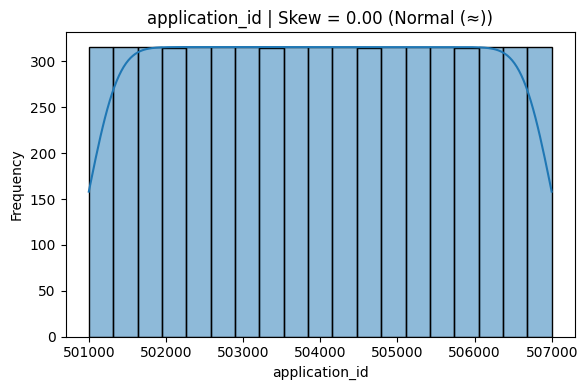

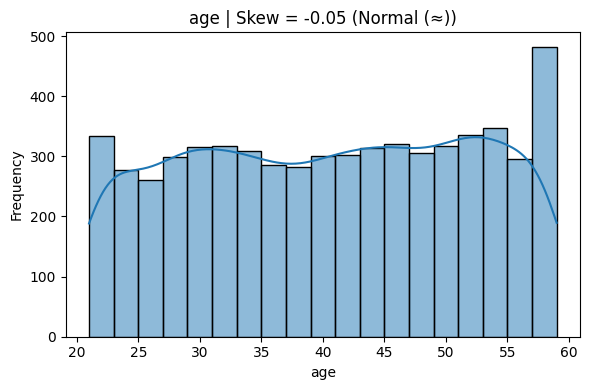

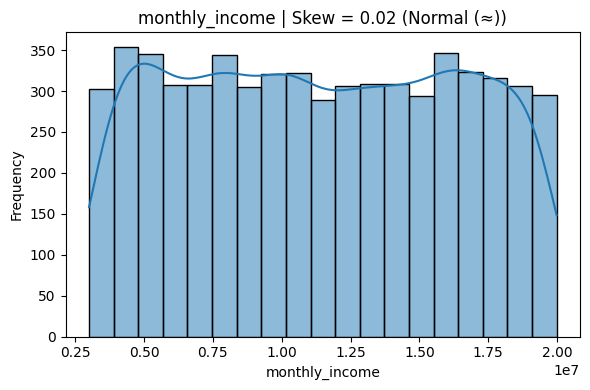

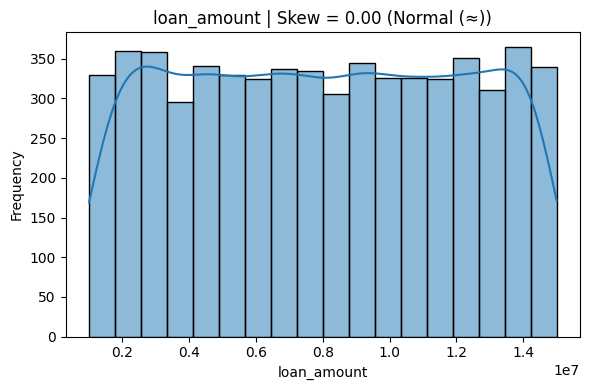

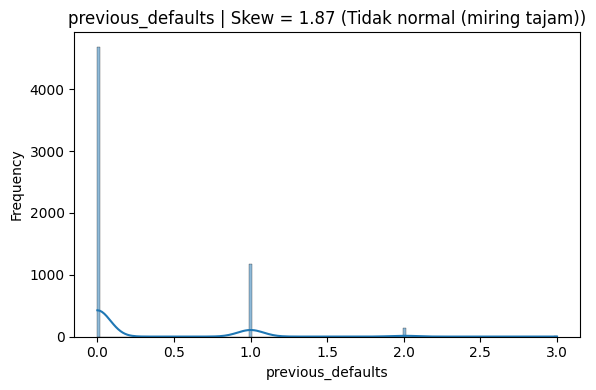

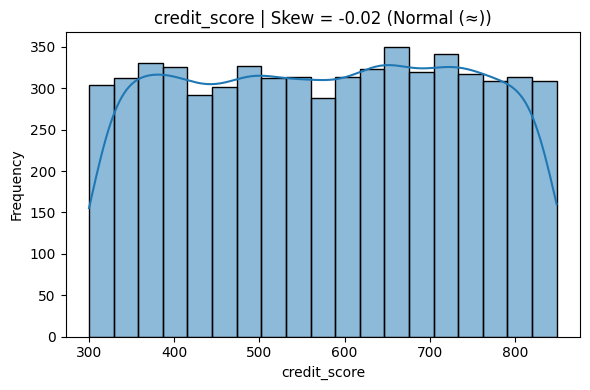

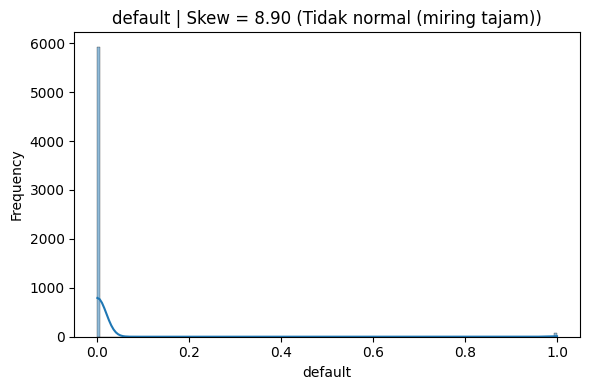

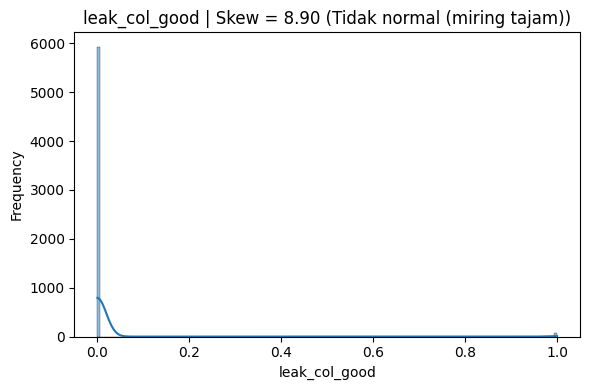

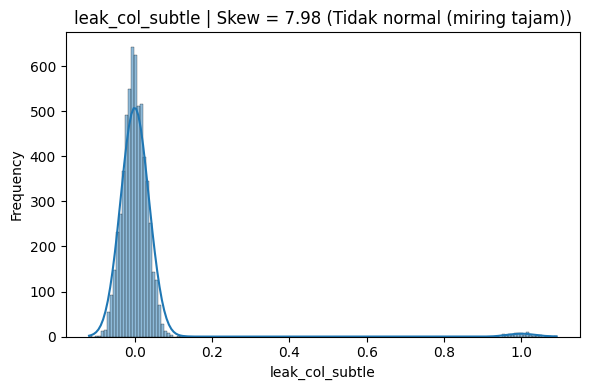

In [15]:
kolom_numerik = df_credit.select_dtypes(include=['float64', 'int64'])
skewness = kolom_numerik.skew()

def interpret_skew(skew):
    if abs(skew) < 0.5:
        return 'Normal (≈)'
    elif abs(skew) < 1:
        return 'Agak miring'
    else:
        return 'Tidak normal (miring tajam)'

hasil = pd.DataFrame({
    'Skewness': skewness,
    'Interpretasi': skewness.apply(interpret_skew)
}).sort_values(by='Skewness', key=abs, ascending=False)

for col in kolom_numerik.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_credit[col], kde=True)
    plt.title(f'{col} | Skew = {df_credit[col].skew():.2f} ({interpret_skew(df_credit[col].skew())})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [16]:
duplikat = df_credit.duplicated(subset='application_id', keep=False)
jumlah_duplikat = duplikat.sum()
df_duplikat = df_credit[duplikat]

print(f'Jumlah duplikat berdasarkan application_id: {jumlah_duplikat}')

Jumlah duplikat berdasarkan application_id: 0


default
0    5927
1      73
Name: count, dtype: int64


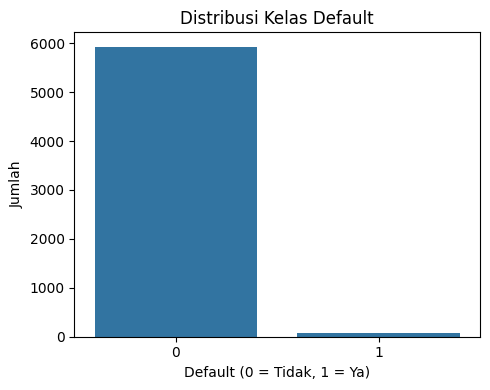

In [17]:
default_counts = df_credit['default'].value_counts()
print(default_counts)

plt.figure(figsize=(5, 4))
sns.countplot(data=df_credit, x='default')
plt.title('Distribusi Kelas Default')
plt.xlabel('Default (0 = Tidak, 1 = Ya)')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

# Preprocessing

In [17]:
kolom_yang_dihapus = ['leak_col_good', 'leak_col_subtle']  
df_credit = df_credit.drop(columns=kolom_yang_dihapus)

# Modeling

In [18]:
from sklearn.model_selection import train_test_split

X = df_credit.drop(columns=['default','application_id'])
y = df_credit['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Extra Trees': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),  
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=1)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, probs)
    
    print(f'\n{name} AUC: {auc:.4f}')
    print(f'{name} Classification Report:')
    print(classification_report(y_test, preds))


Logistic Regression AUC: 0.6762
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1185
           1       0.02      0.60      0.04        15

    accuracy                           0.64      1200
   macro avg       0.51      0.62      0.41      1200
weighted avg       0.98      0.64      0.77      1200


Extra Trees AUC: 0.6936
Extra Trees Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200


HistGradientBoosting AUC: 0.5747
HistGradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00

In [20]:
from sklearn.ensemble import StackingClassifier

# Base dan final model
base_estimators = [('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))]
final_estimator = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=1)

# Stacking model
stack_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,  
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train, y_train)
preds = stack_model.predict(X_test)
probs = stack_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)

print(f"\nStacking Model (Base = LR, Final = XGB) AUC: {auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, preds))


Stacking Model (Base = LR, Final = XGB) AUC: 0.6314
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200



# Modeling + SMOTE

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Extra Trees': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),  
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=1)
}

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    probs = model.predict_proba(X_test)[:, 1]
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, probs)
    
    print(f'\n{name} AUC: {auc:.4f}')
    print(f'{name} Classification Report:')
    print(classification_report(y_test, preds))


Logistic Regression AUC: 0.6762
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1185
           1       0.02      0.53      0.04        15

    accuracy                           0.64      1200
   macro avg       0.50      0.59      0.41      1200
weighted avg       0.98      0.64      0.77      1200


Extra Trees AUC: 0.6276
Extra Trees Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1185
           1       0.05      0.13      0.07        15

    accuracy                           0.96      1200
   macro avg       0.52      0.55      0.53      1200
weighted avg       0.98      0.96      0.97      1200


HistGradientBoosting AUC: 0.5377
HistGradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1185
           1       0.03

In [23]:
from sklearn.ensemble import StackingClassifier

# Base dan final model
base_estimators = [('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))]
final_estimator = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=1)

# Stacking model
stack_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_estimator,
    passthrough=False,  
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train_smote, y_train_smote)
preds = stack_model.predict(X_test)
probs = stack_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, probs)

print(f"\nStacking Model (Base = LR, Final = XGB) AUC: {auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, preds))


Stacking Model (Base = LR, Final = XGB) AUC: 0.7093
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78      1185
           1       0.02      0.67      0.05        15

    accuracy                           0.65      1200
   macro avg       0.51      0.66      0.41      1200
weighted avg       0.98      0.65      0.77      1200



# Fungsi Scorecard

In [8]:
def prob_to_score(prob, min_score=300, max_score=850):
    return (1 - prob) * (max_score - min_score) + min_score


logreg_probs = models['Logistic Regression'].predict_proba(X_test)[:, 1]
logreg_scores = prob_to_score(logreg_probs)

hasil_skoring = pd.DataFrame({'Probability': logreg_probs, 'Credit_Score': logreg_scores})
hasil_skoring

,Probability,Credit_Score
0,0.279608,696.215827
1,0.605801,516.809450
2,0.032088,832.351807
3,0.351153,656.865793
4,0.288099,691.545451
...,...,...
1195,0.104828,792.344798
1196,0.134907,775.801323
1197,0.272290,700.240334
1198,0.554169,545.207225


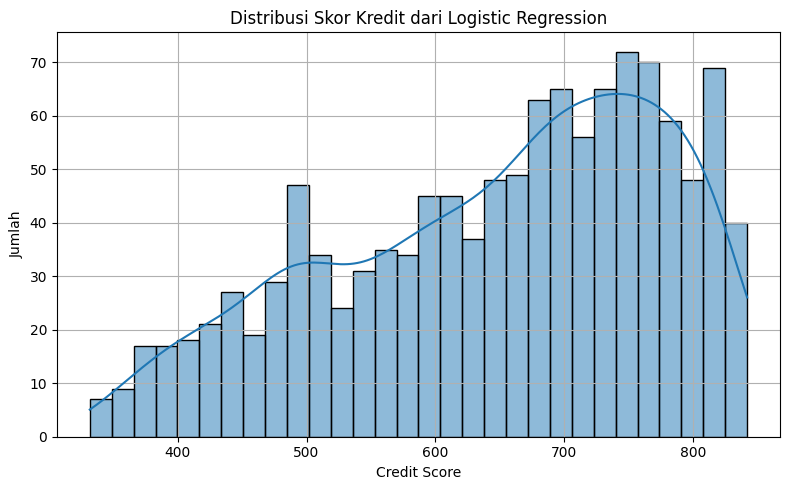

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(logreg_scores, bins=30, kde=True)
plt.title('Distribusi Skor Kredit dari Logistic Regression')
plt.xlabel('Credit Score')
plt.ylabel('Jumlah')
plt.grid(True)
plt.tight_layout()
plt.show()

# SHAP

<Axes: xlabel='mean(|SHAP value|)'>

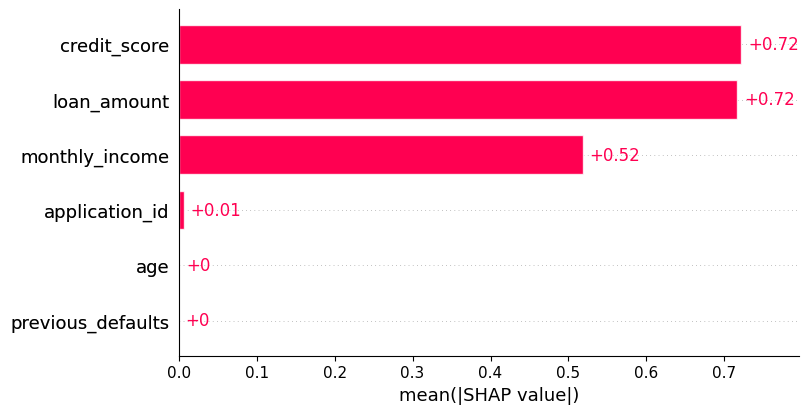

In [ ]:
import shap

explainer = shap.Explainer(models['Logistic Regression'], X_train)
shap_values = explainer(X_train)

shap.plots.bar(shap_values[:, :10], show=False)

In [15]:
plt.tight_layout()
plt.savefig("shap_top10_logreg.png", dpi=300)
plt.close()

# Test 5 Juta

In [ ]:
contoh_5juta = df_credit[(df_credit['loan_amount'] >= 4900000) & (df_credit['loan_amount'] <= 5100000)].sample(1, random_state=42)

X_contoh = contoh_5juta.drop(columns=['application_id', 'default', 'credit_score']) 